In [45]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer,AutoModelForMaskedLM,AutoConfig
import numpy
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
from torch.utils.data import random_split,Dataset

In [46]:
data = load_dataset("saheedniyi/naijaweb")

In [47]:
data['train'][0:3]

{'text': ['Governor Samuel Ortom of Benue State\nBy Peter Duru\nGovernor Samuel Ortom of Benue state has commended President Muhammadu Buhari for his directive to security agents to shoot anyone illegally bearing AK47 rifle in the country.\nThe Governor who gave the commendation Thursday in Makurdi said the President’s order would reduce the level of criminality, banditry and militia herders’ attacks on Benue communities as well as in other parts of the country.\nAccording to him, “the order would also make the communities safer for displaced farmers to return to their ancestral homes.\n“I wish to commend Mr. President for his recent order against those bearing AK47 rifles. This I am sure will reduce the high rate of criminality, banditary and militia herdsmen attacks on our farming communities,” the Governor said.\nHe noted that President Buhari had done the right thing by listening to the calls he and other concerned Nigerians made on the need for the Federal Government to act faster

In [48]:
from sklearn.preprocessing import LabelEncoder

data = data['train'].to_pandas()
data = data[['text','section']].copy()

encoder = LabelEncoder()
data['section'] = encoder.fit_transform(data['section'])
data.head()


,text,section
0,Governor Samuel Ortom of Benue State\nBy Peter...,12
1,NewsHelm.com offers a unique blend of modernit...,12
2,BY LEVINUS NWABUGHIOGU & EMMAN OVUAKPORIE\nABU...,12
3,Eyitayo Jegede and Jimoh Ibrahim\nBy Ikechukwu...,12
4,"Mrs. Helen Mark, wife of Senator David Mark, p...",12


In [49]:
data.rename(columns = {
    'section':'label'
}, inplace = True)

In [50]:
data['label'].value_counts()

label
12    131126
19     26643
16     20739
0      15478
4      12084
14     11755
8      11637
15      6131
18      5857
11      5230
5       4023
2       3107
1       2800
6       2469
13      2263
10      2221
17      2191
3       1968
7       1607
9        808
Name: count, dtype: int64

In [51]:
data = data.groupby('label').sample(n=808, random_state=23)

In [52]:
data.reset_index(drop = True, inplace=True)

In [53]:
data.head()

,text,label
0,Dangote Oil Refining Company Limited has said ...,0
1,"Amid on-going economic uncertainty, managers a...",0
2,Marketers still struggle to decide whether con...,0
3,Oil prices have held onto the gains from the l...,0
4,Reliable sources within the financial services...,0


In [54]:
data['label'].value_counts()

label
0     808
1     808
18    808
17    808
16    808
15    808
14    808
13    808
12    808
11    808
10    808
9     808
8     808
7     808
6     808
5     808
4     808
3     808
2     808
19    808
Name: count, dtype: int64

In [55]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size = 0.25, stratify = data['label'])

In [56]:
model_url = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_url)
model = AutoModelForMaskedLM.from_pretrained(model_url)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [57]:
from torch.utils.data import DataLoader
# Custom NaijaDataset class
class NaijaDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.texts = dataframe['text'].tolist() 
        self.labels = dataframe['label'].tolist()  # List of labels (integers)
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets for training and evaluation
train_dataset = NaijaDataset(train_data, tokenizer)
test_dataset = NaijaDataset(test_data, tokenizer)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [59]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_url, num_labels = data['label'].nunique())

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
from transformers import AdamW
from tqdm import tqdm

# Setup optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Store loss values for plotting
train_losses = []
eval_losses = []

# Store predictions and true labels for classification report
all_preds = []
all_labels = []

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training loop
    model.train()
    running_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(logits, dim=1)


    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f"Train Loss: {train_loss:.4f}")

    # Evaluation loop
    model.eval()
    running_loss = 0.0

    # Reset predictions and labels for the eval phase
    epoch_preds = []
    epoch_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            running_loss += loss.item()

            # Collect predictions and labels for classification report and confusion matrix
            _, predicted = torch.max(logits, dim=1)
            epoch_preds.extend(predicted.cpu().numpy())
            epoch_labels.extend(labels.cpu().numpy())


    eval_loss = running_loss / len(test_loader)
    eval_losses.append(eval_loss)
    print(f"Eval Loss: {eval_loss:.4f}")

    # Store predictions and labels for the entire evaluation phase
    all_preds.extend(epoch_preds)
    all_labels.extend(epoch_labels)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3


Training: 100%|██████████| 379/379 [05:07<00:00,  1.23it/s]


Train Loss: 1.6946


Evaluating: 100%|██████████| 127/127 [00:40<00:00,  3.12it/s]


Eval Loss: 1.2630

Epoch 2/3


Training: 100%|██████████| 379/379 [05:06<00:00,  1.24it/s]


Train Loss: 1.0780


Evaluating: 100%|██████████| 127/127 [00:39<00:00,  3.19it/s]


Eval Loss: 1.2455

Epoch 3/3


Training: 100%|██████████| 379/379 [05:06<00:00,  1.24it/s]


Train Loss: 0.8721


Evaluating: 100%|██████████| 127/127 [00:40<00:00,  3.14it/s]

Eval Loss: 1.2638


In [62]:
# Generate classification report and confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50       606
           1       0.88      0.84      0.86       606
           2       0.49      0.40      0.44       606
           3       0.68      0.64      0.66       606
           4       0.72      0.68      0.70       606
           5       0.57      0.44      0.50       606
           6       0.75      0.81      0.78       606
           7       0.74      0.81      0.77       606
           8       0.59      0.64      0.61       606
           9       0.72      0.71      0.72       606
          10       0.89      0.80      0.84       606
          11       0.82      0.82      0.82       606
          12       0.49      0.62      0.55       606
          13       0.53      0.77      0.63       606
          14       0.63      0.77      0.69       606
          15       0.57      0.53      0.55       606
          16       0.82      0.96      0.88       606
   

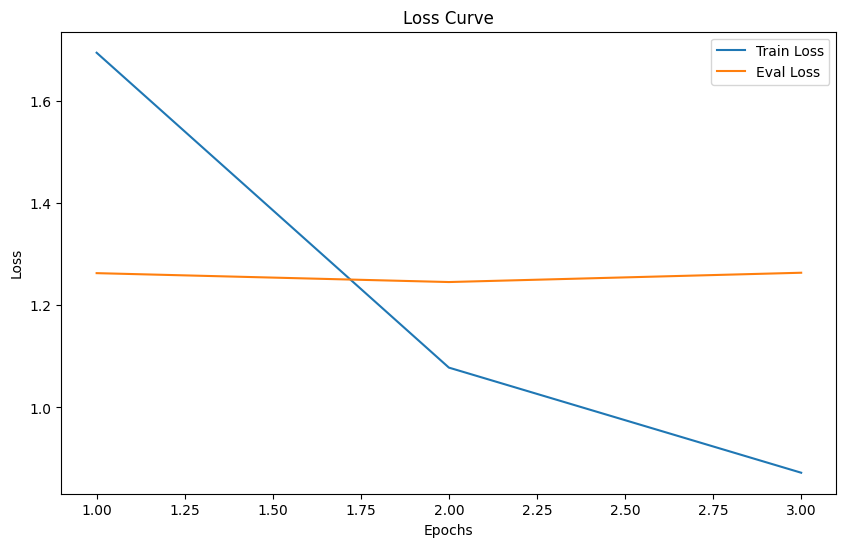

In [68]:
# Plotting the loss curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs + 1), eval_losses, label="Eval Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

In [69]:
torch.save(model.state_dict(), "model_v1.pth")